# Exercise 8: Self Supervised Learning

**Summer Semester 2025**

**Author**: Nick Stracke (nick.stracke@lmu.de)

## Instructions

Parts where code should be added are marked using `TODO`. You shouldn't have to edit anything else with the exception of imports.

*Please* add extensive comments to your code to explain what you're doing/trying to do. It is hard to assign partial points for incorrect or incomplete solutions if we do not understand what you are trying to do.

# Task 1: Temperature in Self Supervised Learning

In [35]:
import torch
import matplotlib.pyplot as plt

### Task 1.1: Visualizing the Effect of Temperature

In [36]:
def softmax_temp(logits: torch.Tensor, tau: float = 1.0) -> torch.Tensor:
    """
    Applies the softmax function with temperature.

    Parameters:
        logits (torch.Tensor, shape (N,)): A tensor containing the raw scores or logits.
        tau (float, optional): The temperature parameter to scale the logits. Default is 1.0.

    Returns:
        torch.Tensor: A tensor containing the probabilities after applying the softmax function.
    """
    scaled_logits = logits/tau
    max_logits = torch.max(scaled_logits, dim=-1, keepdim=True).values
    stabilized_logits = scaled_logits - max_logits
    
    exp_logits = torch.exp(stabilized_logits)
    
    sum_exp = torch.sum(exp_logits, dim=-1, keepdim=True)
    softmax = exp_logits / sum_exp
    
    
    return softmax

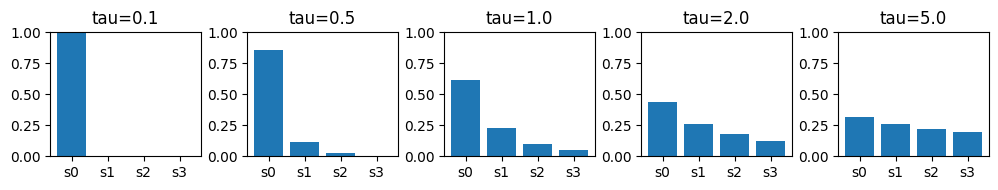

In [37]:
sims = torch.tensor([2.0, 1.0, 0.2, -0.5])
temps = [0.1, 0.5, 1.0, 2.0, 5.0]

fig, ax = plt.subplots(1, len(temps), figsize=(int(2 * len(temps)), 2))
for i, tau in enumerate(temps):
    ax[i].bar(range(len(sims)), softmax_temp(sims, tau).numpy())
    ax[i].set_title(f"tau={tau}")
    ax[i].set_xticks(range(len(sims)))
    ax[i].set_xticklabels([f"s{i}" for i in range(len(sims))])
    ax[i].set_ylim(0, 1)
plt.tight_layout()
plt.show()

### Task 1.2: Intuition: Confidence vs. Uncertainty

##### What happens to the distribution when the temperature is very low (e.g., τ = 0.1)? What does this mean in terms of model confidence?

*it makes the output more confident (peaky)*

##### What happens when τ is very high (e.g., τ = 10.0)? What does this mean for the model’s ability to focus?

*makes the output softer (more uniform) and can lead to nonsense*

### Task 1.3: Why Temperature Matters in Contrastive Learning

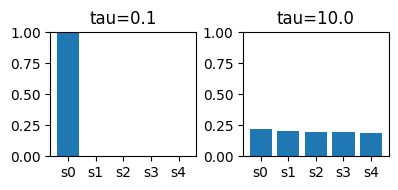

In [38]:
sims = torch.tensor([1.0, 0.2, 0.1, -0.1, -0.3])
temps = [0.1, 10.0]

fig, ax = plt.subplots(1, len(temps), figsize=(int(2 * len(temps)), 2))
for i, tau in enumerate(temps):
    ax[i].bar(range(len(sims)), softmax_temp(sims, tau).numpy())
    ax[i].set_title(f"tau={tau}")
    ax[i].set_xticks(range(len(sims)))
    ax[i].set_xticklabels([f"s{i}" for i in range(len(sims))])
    ax[i].set_ylim(0, 1)
plt.tight_layout()
plt.show()

##### Discuss: Why might a sharper distribution (lower τ ) help the model learn more effectively?

*Because a lower τ makes the model more confident in distinguishing positive (TP) pairs from negative (TN)
 pairs by amplifying the differences in similarity scores.*

# Task 2: SimCLR

In [27]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from ex8_2 import SimCLRModel
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision
from tqdm import tqdm
import torch.nn as nn

### Task 2.1: Implement and Train a SimCLR Model
##### Switch to ex2.py to complete the implementation and train the SimCLR model. Come back here once you have a trained checkpoint.

### Task 2.2: Visualize with t-SNE

In [32]:
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
test_batch_size = 256
model = SimCLRModel()
model.load_state_dict(torch.load("simclr_model.pth", map_location="cpu"))
model.eval()
model.to(device)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=T.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, train_labels in tqdm(test_loader):
        imgs = imgs.to(device)
        embedings = model.encoder(imgs)
        all_embeddings.append((embedings.cpu()))
        all_labels.append(train_labels)

all_embeddings = torch.cat(all_embeddings, dim=0).squeeze().numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

subset_embeddings = all_embeddings[:1000]  # Subset for faster t-SNE
subset_labels = all_labels[:1000]

print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
tsne_result = tsne.fit_transform(subset_embeddings)

# --- Plotting ---
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=subset_labels, cmap='tab10', s=10)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE of CIFAR-10 Test Set Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'simclr_model.pth'

### Task 2.3: Quantitative Evaluation using Linear Probing

In [33]:
# CONFIG
num_classes = 10  # CIFAR-10 has 10 classes
train_batch_size = 256
epochs = 50

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=T.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False, num_workers=0)

train_features, train_labels = [], []
with torch.no_grad():
    for x, y in tqdm(train_loader):
        x = x.to(device)
        embedings_en = model.encoder(x)
        all_embeddings.append(embedings_en.cpu())
        all_labels.append(y)

train_features = torch.cat(train_features)
train_labels = torch.cat(train_labels)

RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [34]:
# TODO: define the linear probe, optimizer and classification loss here
probe = torch.nn.Linear(train_features.shape[1], num_classes).to(device)
optimizer = torch.optim.Adam(probe.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()
# Train probe
for epoch in range(epochs):
    perm = torch.randperm(train_features.size(0))
    train_features, train_labels = train_features[perm], train_labels[perm]
    total_loss = 0
    for i in range(0, len(train_features), train_batch_size):
        xb = train_features[i:i+train_batch_size].to(device)
        yb = train_labels[i:i+train_batch_size].to(device)
        
        optimizer.zero_grad()
        logits= probe(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * xb.size(0)
        
    axg_loss = total_loss / len(train_features)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {axg_loss:.4f}")

NameError: name 'train_features' is not defined

In [ ]:
test_features = []
test_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        feats = model.encoder(x)
        test_features.append(feats.cpu())
        test_labels.append(y)

test_features = torch.cat(test_features).to(device)
test_labels = torch.cat(test_labels).to(device)

with torch.no_grad():
    logits = probe(test_features)
    preds = logits.argmax(dim=1)
    accuracy = (preds == test_labels).float().mean().item()

print(f"Linear probe test accuracy: {accuracy * 100:.2f}%")


# Task 3: CLIP for Zero-Shot Classification

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import matplotlib.pyplot as plt
import requests

###  Task 3.2: Implement a Zero-Shot Classifier with CLIP

In [ ]:
# Load pretrained CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.eval()

# Example images
image_urls = [
    "https://images.unsplash.com/photo-1518717758536-85ae29035b6d",  # dog
    "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba",  # cat
    # TODO: add some more images
]

images = [Image.open(requests.get(url, stream=True).raw).convert("RGB") for url in image_urls]

In [ ]:
text_prompts = [
    "a photo of a dog",
    "an image of a cat",
    "a photo of a animal",
    "a photo of a horse",
    "a photo of a car",
    # TODO: add some more text prompts
    # try to play around with how you phrase the text prompts and how that affects the predictions
]

In [ ]:
# Prepare inputs for CLIP
inputs = processor(text=text_prompts, images=images, return_tensors="pt", padding=True)

probs: torch.Tensor = None # shape [num_images, num_texts]

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # shape [num_images, num_texts]
    probs = logits_per_image.softmax(dim=1)  
    

In [ ]:
# Print predictions
for i, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"PREDICTED: {text_prompts[probs[i].argmax()]}")
    plt.show()
    print("Probabilities:")
    for j, txt in enumerate(text_prompts):
        print(f"  {txt:<25}: {probs[i][j]:.2f}")
    print()

### Task 3.3: Discussion

##### Try varying your text prompts. Does the classification change?

*your answer...*

##### What kind of errors does CLIP make? Are they semantically reasonable?

*your answer...*

##### How does this compare to traditional classification models?

*your answer...*